# Robustness Evalualtion for Detection of Cats and Dogs

Required packages:

  - hydra-zen: `pip install hydra-zen`
  - rai-toolbox: `pip install rai-toolbox[mushin]`
  - pytorch-lightning: `pip install pytorch_lightning`
  - kornia: `pip install kornia`
  - mlflow: `pip install mlflow`
  - huggingface_hub: `pip install huggingface_hub`
  - HuggingFace datasets: `pip install datasets`
  - HuggingFace transformers: `pip install transformers`

## Imports

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

from pathlib import Path

import torch as tr
from hydra_zen import instantiate

from jatic_toolbox.interop.hydra_zen import jatic_store, create_huggingface_dataset_config, create_huggingface_model_config, create_smqtk_model_config


## Configure and Load the Cats and Dogs Dataset

In [55]:
create_huggingface_dataset_config("biglam/nls_chapbook_illustrations")

jatic-interop
{'dataset': ['Bingsu__Cat_and_Dog', 'biglam__nls_chapbook_illustrations'], 'model': ['hustvl__yolos-tiny', 'hustvl__yolos-base', 'hustvl__yolos-small', 'hustvl__yolos-small-dwr', 'hustvl__yolos-small-300', 'gary109__STAS_yolos-small', 'gary109__STAS_yolos-base', 'nickmuchi__yolos-small-finetuned-masks', 'nickmuchi__yolos-base-finetuned-masks', 'nickmuchi__yolos-small-rego-plates-detection', 'nateraw__yolov6n', 'nateraw__yolov6s', 'nateraw__yolov6t', 'nickmuchi__yolos-small-finetuned-license-plate-detection', 'hf-internal-testing__tiny-random-yolos', 'zoheb__yolos-small-balloon', 'nickmuchi__yolos-small-plant-disease-detection', 'valentinafeve__yolos-fashionpedia', 'hf-internal-testing__tiny-random-YolosForObjectDetection', 'smqtk__centernet-resnet50', 'smqtk__centernet-resnet18', 'smqtk__centernet-res2net50']}

NameError: name 'to_yaml' is not defined

Found cached dataset nls_chapbook_illustrations (/home/justin_goodwin/.cache/huggingface/datasets/biglam___nls_chapbook_illustrations/illustration-detection/1.0.0/bab1989ea05996f5c8c55e1c10c0209b2936cb1ec3faa2f89a7ed7cab0193ea4)


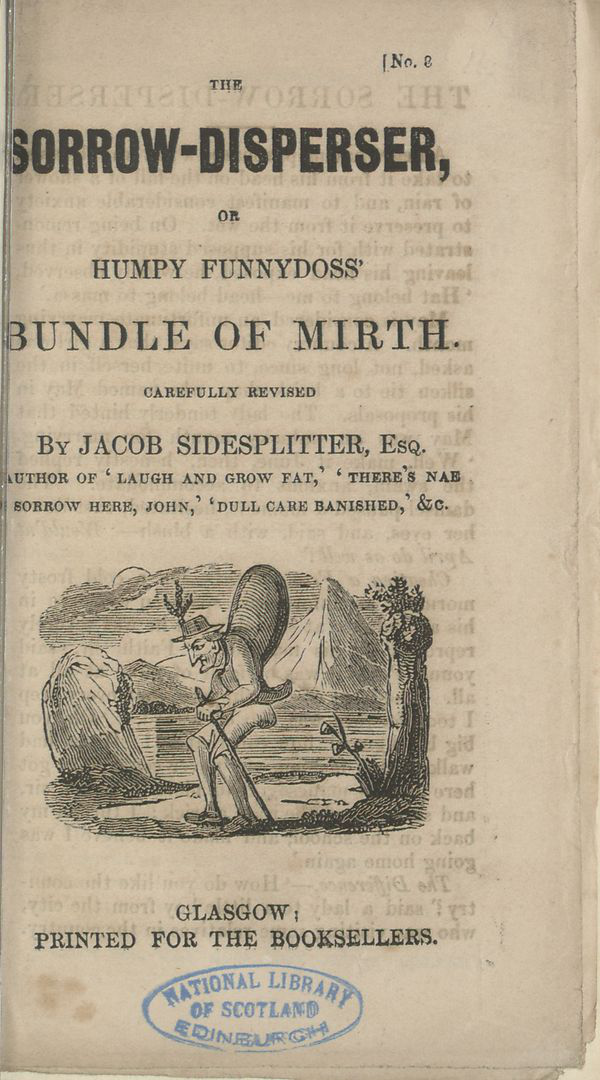

In [68]:
dataset = instantiate(jatic_store[("dataset", 'biglam__nls_chapbook_illustrations')], name='illustration-detection', split="train")
dataset[0]["image"]

In [69]:
from huggingface_hub import (
    DatasetSearchArguments,
    HfApi,
    ModelFilter,
    ModelSearchArguments,
)

api = HfApi()
model_args = ModelSearchArguments()
dataset_args = DatasetSearchArguments()

filt = ModelFilter(
    task=model_args.pipeline_tag.ObjectDetection,
    model_name="detr",
    library=model_args.library.PyTorch,
    
)

create_huggingface_model_config(filter=filt)

/home/justin_goodwin/.conda/envs/raise/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:233: FutureWarning: 'list_models' currently returns a list of objects but is planned to be a generator starting from version 0.14 in order to implement pagination. Please avoid to use `list_models(...).__len__` or explicitly convert the output to a list first with `list(iter(list_models)(...))`.
  warnings.warn(self._deprecation_msg.format(attr_name=attr_name), FutureWarning)


jatic-interop
{'dataset': ['Bingsu__Cat_and_Dog', 'biglam__nls_chapbook_illustrations'], 'model': ['hustvl__yolos-tiny', 'hustvl__yolos-base', 'hustvl__yolos-small', 'hustvl__yolos-small-dwr', 'hustvl__yolos-small-300', 'gary109__STAS_yolos-small', 'gary109__STAS_yolos-base', 'nickmuchi__yolos-small-finetuned-masks', 'nickmuchi__yolos-base-finetuned-masks', 'nickmuchi__yolos-small-rego-plates-detection', 'nateraw__yolov6n', 'nateraw__yolov6s', 'nateraw__yolov6t', 'nickmuchi__yolos-small-finetuned-license-plate-detection', 'hf-internal-testing__tiny-random-yolos', 'zoheb__yolos-small-balloon', 'nickmuchi__yolos-small-plant-disease-detection', 'valentinafeve__yolos-fashionpedia', 'hf-internal-testing__tiny-random-YolosForObjectDetection', 'smqtk__centernet-resnet50', 'smqtk__centernet-resnet18', 'smqtk__centernet-res2net50', 'davanstrien__detr_beyond_words', 'facebook__detr-resnet-101-dc5', 'facebook__detr-resnet-101', 'facebook__detr-resnet-50-dc5', 'facebook__detr-resnet-50', 'hf-inter

In [70]:
model = instantiate(jatic_store[("model", "facebook__detr-resnet-50")])
None

/home/justin_goodwin/.conda/envs/raise/lib/python3.10/site-packages/transformers/models/detr/image_processing_detr.py:773: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [71]:
from typing import Iterable
from jatic_toolbox.protocols import ArrayLike, ObjectDetection, ObjectDetectionOutput

def eval_image_detector(
    detector: ObjectDetection, img_iter: Iterable[ArrayLike], threshold: float = 0.4
) -> Iterable[ObjectDetectionOutput]:
    """Evalulator for Object Detection Models.

    Parameters
    ----------
    detector: ImageDetector
    img_iter: Iterable[ArrayLike]
    threshold: float = 0.4

    Returns
    -------
    DetectorOutput
    """
    output = detector(img_iter)

    threshold_output = []
    for dets in output:
        boxes_threshold = []
        scores_threshold = []
        for i, (boxes, score_dict) in enumerate(zip(dets.boxes, dets.scores)):
            if threshold > 0.0:
                cls_idx = max(score_dict, key=score_dict.get)
                conf = score_dict[cls_idx]

                if conf >= threshold:
                    boxes_threshold.append(boxes)
                    scores_threshold.append({cls_idx: conf})
            else:
                boxes_threshold.append(boxes)
                scores_threshold.append(score_dict)

        threshold_output.append(
            ObjectDetectionOutput(boxes=boxes_threshold, scores=scores_threshold)
        )
    return threshold_output


In [72]:
from matplotlib.patches import Rectangle

def show_dets(ax, dets: ObjectDetectionOutput):
    for i, (bbox, score_dict) in enumerate(zip(dets.boxes, dets.scores)):
        cls_idx = max(score_dict, key=score_dict.get)
        conf = score_dict[cls_idx]

        x1, y1 = bbox.min_vertex
        x2, y2 = bbox.max_vertex
        ax.add_patch(
            Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=1,
                edgecolor="r",
                facecolor="none",
            )
        )


In [73]:
model.model.eval()

val = model.feature_extractor([img], return_tensors="pt")
outputs = model.model(**val)
probs = tr.softmax(outputs.logits, dim=-1)
probs.shape

torch.Size([1, 100, 92])

Text(0.5, 1.0, 'Predicted Label: [91]')

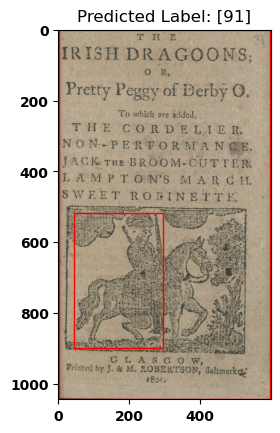

In [74]:
img = dataset[2]["image"]
dets = eval_image_detector(model, [img], threshold=0.1)

fig, ax = plt.subplots()
ax.imshow(img)
show_dets(ax, dets[0])


labels = list(dets[0].scores[0].keys())
plt.title(f"Predicted Label: {labels}")



In [54]:
# logits = tr.stack((logits[:, 281:285].sum(1), logits[:, 151:268].sum(1)), dim=1)
# metric_val = self.metrics(logits, targets)

list(dets[0].scores)
# model.model.config.id2label


[{91: 0.7639307975769043},
 {91: 0.8026494979858398},
 {91: 0.5231908559799194},
 {91: 0.6441336274147034},
 {84: 0.5286672115325928},
 {91: 0.8650166392326355},
 {91: 0.807966947555542},
 {91: 0.9930843114852905},
 {91: 0.9587448239326477},
 {91: 0.7042210102081299},
 {84: 0.7926677465438843},
 {84: 0.6601555943489075},
 {91: 0.9130509495735168},
 {91: 0.9865759611129761},
 {84: 0.4967735707759857},
 {91: 0.9074096083641052}]

## Execute Task Function

Show available configurations for `image_classifier` groups.

In [ ]:
cs = ConfigStore.instance()
# Hydra stores the key with `.yaml`. This still works for multirun but prefer
# to remove the `.yaml` from the model name.
[k.split('.',1)[0] for k in cs.repo["image_classifier"].keys()]

In [ ]:
# run experiment for different seeds
seeds = tr.randint(0, 1000, size=(10,)).tolist()

# run experiment for each image classifier model
models = [k.split(".", 1)[0] for k in cs.repo["image_classifier"].keys()]

# run experiment for different random rotations
# e.g., [0, 25] constrains rotations between 0 and 25 degrees
severity = [[0, 25], [25, 50], [50, 75], [75, 90]]

# For testing or local runs:
# seeds = seeds[:1]
# models = models[:1]
# severity = [[0, 25], [25, 50], [50, 75], [75, 90]]

#
# LAUNCH
#
wf = LightningImageClassifier(Config)
wf.run(
    # run with random seeds
    global_seed=multirun(seeds),
    # run all configured `image_classifier`s
    image_classifier=multirun(models),
    # run the configured corruption
    corruption="kornia__random_affine",
    # run on different values of "severity" for the corruption
    severity=multirun(severity),
    # Hydra options
    version_base="1.1",
    to_dictconfig=True,
    # comment out if you aren't running on slurm or set parameters to your cluster
    overrides=[
        "hydra/launcher=submitit_slurm",
        "hydra.launcher.name=JATIC",
        "hydra.launcher.nodes=1",
        "hydra.launcher.tasks_per_node=2",
        "hydra.launcher.timeout_min=6000",
        "hydra.launcher.partition=gpu",
        "hydra.launcher.gres=gpu:v100:2",
    ],
)


### Load Data


You can view the results with MLFlow using `mlflow ui` in the `multiruns` directory or see below for a programmatic approach.

In [ ]:
from mlflow import MlflowClient, set_tracking_uri
from mlflow.entities import ViewType

set_tracking_uri("./multirun/mlruns")
runs = MlflowClient().search_runs(
    experiment_ids="1", filter_string="attribute.status = 'FINISHED'",
    order_by=["metrics.accuracy DESC"]
)


Create an Xarray `Dataset` from the all the runs.

In [ ]:
from collections import defaultdict
data = defaultdict(list)
for run in runs:
    if "accuracy" in run.data.metrics:
        for k, v in run.data.metrics.items():
            if k == "hydra/callbacks" or k == "hydra/launcher" or k == "epoch":
                continue
            data[k].append(v)

        for k, v in run.data.params.items():
            if k == "hydra/callbacks" or k == "hydra/launcher" or k == "epoch":
                continue
            data[k].append(v)
    
import xarray as xr
metrics = xr.Dataset({k: ("index", v) for k, v in data.items()})
metrics = metrics.assign_coords(global_seed=("index", metrics.global_seed.values))
metrics = metrics.assign_coords(image_classifier=("index", metrics.image_classifier.values))
metrics = metrics.assign_coords(corruption=("index", metrics.corruption.values))
metrics = metrics.assign_coords(severity=("index", metrics.severity.values))

metrics

Now plot the Xarray `Dataset`.

In [ ]:
import numpy as np


models = np.unique(metrics.image_classifier)
severities = np.unique(metrics.severity)

fig, ax = plt.subplots(figsize=(18,4), ncols=len(models), sharex=True, sharey=True, tight_layout=True)
cm = plt.cm.get_cmap("Set1").colors

for i, model in enumerate(models):
    ind = (metrics.image_classifier == model)
    idata = metrics.accuracy[ind].set_index(index=["global_seed", "severity"]).unstack("index")
    
    mean_acc = idata.mean(dim="global_seed").values
    std_acc = idata.std(dim="global_seed").values

    ax[i].plot(idata.severity.values, mean_acc, color=cm[i], zorder=i)
    ax[i].fill_between(idata.severity.values, mean_acc - std_acc, mean_acc + std_acc, color=cm[i], zorder=i, alpha=0.3)
    ax[i].set_xlabel("Random Affine Max Degrees (deg)")
    ax[i].set_title(f"{model}")
